In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as sts
import seaborn as sns
from sklearn.metrics import f1_score


In [2]:
df=pd.read_csv('train.tsv',sep='\t')
df.head()
df.shape

(5758, 2)

# EDA

In [3]:
df['title'].isnull().sum() # good, no missing values.

0

In [4]:
df.is_fake.value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

**Insight**-training data is equally distributed(all comments will be in English, we are datascientists))

In [5]:
df[df['is_fake']==0].sample(n=1)['title'].iloc[0] #example of real news.

'Потанин рассказал о предложении выкупить долю Русала в Норникеле'

In [6]:
df[df['is_fake']==1].sample(n=1)['title'].iloc[0]# fake

'На следующих президентских выборах американцы будут голосовать исключительно по почте'

In [7]:
#sentence length(word counts in news)

df['sentence_length'] = df['title'].apply(lambda x: len(x.split(' ')))
df['sentence_length'].describe()

count    5758.000000
mean        8.724731
std         2.811139
min         3.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        37.000000
Name: sentence_length, dtype: float64

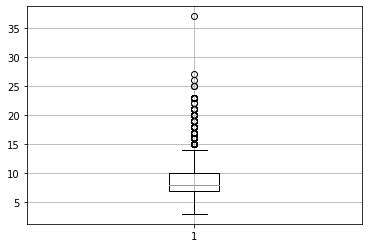

In [8]:
plt.boxplot(df['sentence_length'].values)
plt.grid(True)
plt.show()

**Insight**-Usual length:7-10 words, have some outliers-bigger and equal than 15 approximately.

In [9]:
df

,title,is_fake,sentence_length
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,10
1,Агент Кокорина назвал езду по встречке житейск...,0,8
2,Госдума рассмотрит возможность введения секрет...,1,8
3,ФАС заблокировала поставку скоростных трамваев...,0,7
4,Против Навального завели дело о недоносительст...,1,8
...,...,...,...
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0,9
5754,Правительство застроит Россию нефтепродуктопро...,0,4
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1,13
5756,Туркмения в декабре начнет поставки газа в Китай,0,8


# Data cleaning , processing

In [10]:
import re
import nltk
# nltk.download('punkt') # At first you have to download these nltk packages.
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('russian')) # defining stop_words

lemmatizer = WordNetLemmatizer()
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','«','»'])
def data_preprocessing(review):
  review = re.sub(re.compile('<.*?>'), '', review)
  
  # lowercase
  review = review.lower()
  
  # tokenization
  tokens = nltk.word_tokenize(review) # converts review to tokens
  
  # stop_words removal
  review = [word for word in tokens if word not in stop_words] #removing stop words
  
  # lemmatization
  review = [lemmatizer.lemmatize(word) for word in review]
  
  # join words in preprocessed review
  review = ' '.join(review)
  
  return review
data_preprocessing(df[df['is_fake']==0].sample(n=1)['title'].iloc[0])

'надежда петрова пробилась 1/8 финала уимблдона'

In [11]:
df['preprocessed_review'] = df['title'].apply(lambda review: data_preprocessing(review))
df.iloc[60].preprocessed_review

'из-за сбоя приложения конституция россии могут ввести конституционную монархию'

In [12]:
df.title.values[60]

'Из-за сбоя приложения «Моя конституция» в России могут ввести конституционную монархию'

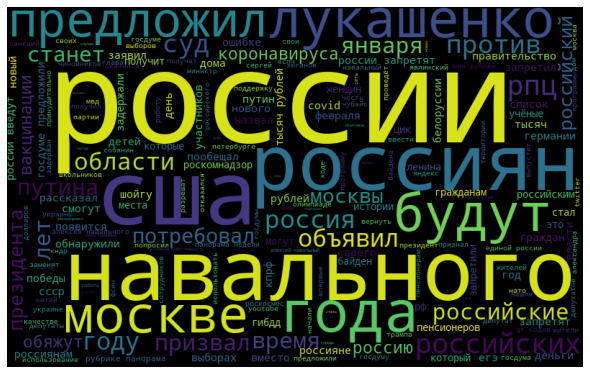

In [13]:

from wordcloud import WordCloud

words_list = df[df['is_fake']==1]['preprocessed_review'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

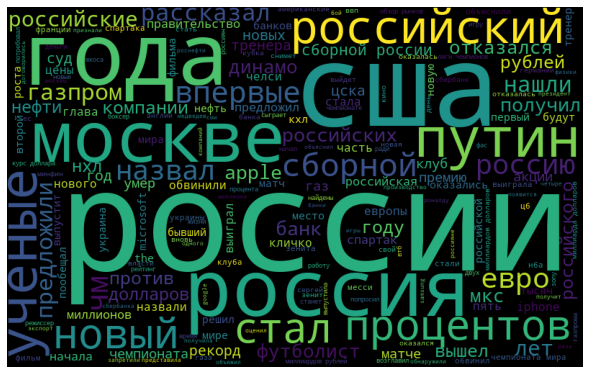

In [14]:
from wordcloud import WordCloud

words_list = df[df['is_fake']==0]['preprocessed_review'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Split to train/test


In [15]:
from sklearn.model_selection import train_test_split

data = df.copy()
y = data['is_fake'].values
data.drop(['is_fake'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (4606, 3) (4606,)
Test data: (1152, 3) (1152,)


# Vectorizing data

## Bow

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=2)

X_train_review_bow = vect.fit_transform(X_train['preprocessed_review'])
X_test_review_bow = vect.transform(X_test['preprocessed_review'])

print('X_train_review_bow shape: ', X_train_review_bow.shape)
print('X_test_review_bow shape: ', X_test_review_bow.shape)

X_train_review_bow shape:  (4606, 5125)
X_test_review_bow shape:  (1152, 5125)


## TFIDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2)

X_train_review_tfidf = vectorizer.fit_transform(X_train['preprocessed_review'])
X_test_review_tfidf = vectorizer.transform(X_test['preprocessed_review'])

print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_review_tfidf.shape)


X_train_review_tfidf shape:  (4606, 5125)
X_test_review_tfidf shape:  (1152, 5125)


# Models

## Naive Bayes: BOW

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 

Test Accuracy:  0.8203125


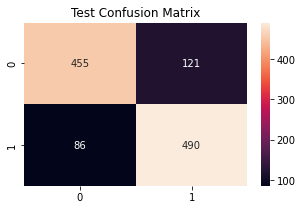

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

##   Naive Bayes: TFIDF

In [20]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.8203125


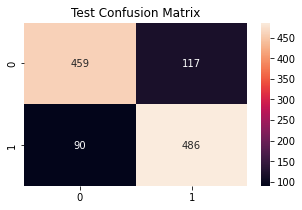

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

## Logistic Regression: TFIDF

In [22]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-8,8,16), "penalty":["l1","l2"]}
clf = LogisticRegression()
logreg_cv=GridSearchCV(clf,grid,cv=10)
logreg_cv.fit(X_train_review_tfidf, y_train)

y_pred = logreg_cv.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.8185763888888888


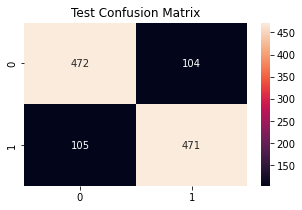

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()